In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
from functools import reduce
import random
import shap
import sqlalchemy
import shap
import warnings
warnings.filterwarnings("ignore")
from python_files.gdsc_all_functions import *
import datetime
import holidays


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import LabelEncoder

In [3]:
def submission_correction(submit_predictions, total_times, times_open, timestamp_col = "predicted_end"):
    submit_predictions.rename(columns={0: "predictions"}, inplace=True)
    total_times = compute_work_item_times(data)
    total_open = total_times[total_times.work_item.isin(times_open.work_item.unique())]
    total_open = pd.merge(total_open, submit_predictions, on="work_item")
    total_open["predicted_end"] = total_open["start"] + total_open["predictions"].apply(lambda x: datetime.timedelta(days=x))
    year_range = range(2015, 2020)
    belhol = holidays.Belgium(years=list(year_range))
# #     correct year
#     total_open["predicted_end"] = total_open["predicted_end"].apply(lambda x: x.replace(year=2018))
#     Correct sunday
    total_open["predicted_end"] = total_open["predicted_end"].apply(lambda x: x + datetime.timedelta(days=1) if x.weekday()+1==7 else x)
#     correct time
    total_open["predicted_end"] = total_open["predicted_end"].apply(lambda x: x.replace(hour=18) if x.hour > 18 else x)
#     correct holiday
    total_open.loc[:, "is_holiday"] = total_open[timestamp_col].apply(lambda t: 1 if t in belhol else 0)
    while len(total_open[total_open["is_holiday"]==1]) > 1:
        total_open["predicted_end"] = total_open["predicted_end"].apply(lambda x: x + datetime.timedelta(days=1) if x in belhol else x)
        total_open.loc[:, "is_holiday"] = total_open[timestamp_col].apply(lambda t: 1 if t in belhol else 0)
#     correct too less prediction
    mindate = datetime.datetime.strptime("2018-03-31", "%Y-%m-%d").date()
    total_open["predicted_end"] = total_open["predicted_end"].apply(lambda x: x.replace(year=2018, month=4, day=13) if x.date() < mindate else x)
    total_open['new_duration'] = total_open['predicted_end'] - total_open['start']
    total_open['new_prediction'] = total_open['new_duration'].apply(lambda x: round(x.total_seconds() / (24*3600), 2))
    return total_open

First we load the raw data, compute the total times for our later y value and get the information which items are still open

In [4]:
filename = Path("/apps/data/common/published/gdsc2_public.csv")
data = load_table(filename)
times = time_for_phase(data)
total_times = compute_work_item_times(set_end_date(data, end_date="2018-12-31"))

In [5]:
process = pd.DataFrame(times.groupby("work_item")["process_index"].apply(lambda x: max(x)))
filtered_wis = process[process["process_index"] > 2].index.values

In [6]:
data = data[data["work_item"].isin(filtered_wis)]

Let's open 30% of the items to train a feature is_open later

In [7]:
# open_items = is_open(data)
# open_items.rename(columns={"is_open":"open_item"}, inplace=True)
# closed_wis = open_items[open_items["open_item"]==0]["work_item"].values
# data_closed = data[data["work_item"].isin(closed_wis)]
# data_closed.sort_values(by=["work_item", "timestamp"], inplace=True)
# topen = int(len(data_closed.work_item.unique()) * 0.3)
# print("We open "+str(topen)+" work items")
# art_open = list(data_closed.work_item.unique())
# random.shuffle(art_open)
# to_del = art_open[:topen]

In [8]:
# def del_some_random_rows(x):
#     x.reset_index(inplace=True)
#     if x.index.max() == 1:
#         x.drop(index=x.index.max(), inplace=True)
#     elif x.index.max() > 1:
#         randnum = random.randint(x.index.min()+1, x.index.max())
#         for i in range(randnum, x.index.max()+1):
#             x.drop(index=i, inplace=True)
#     return x

In [9]:
# dropped = data_closed[data_closed["work_item"].isin(to_del)].groupby("work_item").apply(lambda x: del_some_random_rows(x))
# dropped.index.names = ("dr", "op")
# dropped.reset_index(inplace=True)
# dropped = dropped[data.columns]
# new_data = pd.concat([data[~data["work_item"].isin(to_del)], dropped])

In [10]:
new_data = data

Now we can continue and compute the features.

In [11]:
times = time_for_phase(new_data, end_date="2018-03-31", process=False)
worktime = work_times(times, time_col="duration_in_days", normalize=True)
worktime_time = work_times(times, time_col="duration_in_days", normalize=False)
workfreq = work_times(times)
haloops = has_loops(workfreq)
platclus = plat_comp_cluster(new_data, min_samples=20)
isop = is_open(new_data)

In [12]:
%%time
diff = difficulty(times, compute_work_item_times(new_data))

CPU times: user 8min 9s, sys: 150 ms, total: 8min 9s
Wall time: 8min 9s


In [13]:
rescluster = resource_cluster(times, min_samples=20)
resworkload = resource_workload(times)

In [14]:
holi_days = get_holidays(times)

In [15]:
%%time
resmes = resource_measures(times)

8357 work items to do!
7357 work items to do!
6357 work items to do!
5357 work items to do!
4357 work items to do!
3357 work items to do!
2357 work items to do!
1357 work items to do!
357 work items to do!
CPU times: user 16min 26s, sys: 1.51 s, total: 16min 28s
Wall time: 16min 54s


We want to get information about the start and end timestamp and encode the information

In [16]:
labelenc = LabelEncoder()
time_info_start = timestamp_information(total_times, timestamp_col="start", state="start")
time_info_start["start_year"] = labelenc.fit_transform(time_info_start["start_year"])+1
time_info_end = timestamp_information(total_times, timestamp_col="end", state="end")
time_info_end["end_year"] = labelenc.fit_transform(time_info_end["end_year"])+1
time_info_end = time_info_end[["work_item", "end_year"]]

After that we can merge everything together

In [17]:
final1 = reduce(lambda x, y: pd.merge(x, y, on="work_item", how="inner"),
               [worktime, workfreq, haloops, platclus, isop, diff, rescluster, resworkload, holi_days])

In [18]:
final1.drop_duplicates("work_item", inplace=True)
final1.head()

work_item    Accept   Analyze     Build  Clarify    Deploy    Design  \
0     WI_000001  0.044212  0.193730  0.234325      0.0  0.282154  0.006833   
1452  WI_000002  0.000000  1.000000  0.000000      0.0  0.000000  0.000000   
1488  WI_000003  0.000000  0.818414  0.000000      0.0  0.000000  0.125433   
1880  WI_000004  0.079643  0.458430  0.000000      0.0  0.461927  0.000000   
2272  WI_000005  0.001522  0.782040  0.029833      0.0  0.185693  0.000913   

      End   Package      Test  ...  has_loops  platcomp_cluster  is_open  \
0     0.0  0.157154  0.081592  ...        1.0                 0        0   
1452  0.0  0.000000  0.000000  ...        0.0                 1        0   
1488  0.0  0.000000  0.056153  ...        1.0                 1        0   
1880  0.0  0.000000  0.000000  ...        0.0                 1        0   
2272  0.0  0.000000  0.000000  ...        1.0                 2        0   

      x_diff  resource_cluster  resource_workload  is_holiday  \
0          3                -1            0.09375           0   
1452       2                 0            0.09375           0   
1488      17                 0            0.09375           0   
1880       2                -1            0.09375           0   
2272      11                -1            0.09375           0   

      days_to_nexthol  is_vacation  days_to_nextvac  
0                93.0            1              0.0  
1452             93.0            1              0.0  
1488             93.0            1              0.0  
1880             93.0            1              0.0  
2272             93.0            1              0.0  

[5 rows x 29 columns]

In [20]:
final = reduce(lambda x, y: pd.merge(x, y, on="work_item", how="inner"),
               [final1, resmes, time_info_start, time_info_end, total_times[["work_item", "duration_in_days"]]])

In [12]:
# final.to_csv("/apps/data/common/shared/190412_group2_data_closed.csv", index=False)
final = pd.read_csv("/apps/data/common/shared/190412_group2_data_closed.csv")
final.head()

work_item    Accept   Analyze     Build  Clarify    Deploy    Design  End  \
0  WI_000001  0.044212  0.193730  0.234325      0.0  0.282154  0.006833  0.0   
1  WI_000002  0.000000  1.000000  0.000000      0.0  0.000000  0.000000  0.0   
2  WI_000003  0.000000  0.818414  0.000000      0.0  0.000000  0.125433  0.0   
3  WI_000004  0.079643  0.458430  0.000000      0.0  0.461927  0.000000  0.0   
4  WI_000005  0.001522  0.782040  0.029833      0.0  0.185693  0.000913  0.0   

    Package      Test  ...     x_emp     x_exp    x_load  start_weekday  \
0  0.157154  0.081592  ...  0.002159  0.087180  0.041063              5   
1  0.000000  0.000000  ...  0.102920  0.506024  0.302260              5   
2  0.000000  0.056153  ...  0.412033  3.400098  0.186974              5   
3  0.000000  0.000000  ...  0.225822  0.718473  0.337901              5   
4  0.000000  0.000000  ...  0.053355  1.770698  0.070852              5   

   start_day  start_week  start_month  start_year  end_year  duration_in_days  
0          2           1            1           1         1             24.87  
1          2           1            1           1         1             11.78  
2          2           1            1           1         1             54.85  
3          2           1            1           1         1             25.73  
4          2           1            1           1         1             32.85  

[5 rows x 39 columns]

In [13]:
# final = final[list(set(final.columns)-set(worktime.set_index("work_item").columns))]
# final = pd.merge(final, worktime_time, on="work_item")

In [14]:
skipdays = skipped_days(data, 90)

In [15]:
final = pd.merge(final, skipdays, on="work_item")

Optional: now we add the other given features like domain, work_priority, work_type, ...

In [16]:
final.drop_duplicates("work_item", inplace=True)
final.set_index("work_item", inplace=True)
cols_to_encode = ["work_type", "work_priority"]
encode = new_data[["work_item", *cols_to_encode]].drop_duplicates("work_item")
labelenc = LabelEncoder()
for col in cols_to_encode:
    encode.loc[:, col] = labelenc.fit_transform(encode[col])
# encoded = pd.get_dummies(encode, columns=cols_to_encode)
final = pd.merge(final, encode, left_index=True, right_on="work_item").set_index("work_item")
final.head()

Accept   Analyze     Build  Clarify    Deploy    Design  End  \
work_item                                                                   
WI_000001  0.044212  0.193730  0.234325      0.0  0.282154  0.006833  0.0   
WI_000002  0.000000  1.000000  0.000000      0.0  0.000000  0.000000  0.0   
WI_000003  0.000000  0.818414  0.000000      0.0  0.000000  0.125433  0.0   
WI_000004  0.079643  0.458430  0.000000      0.0  0.461927  0.000000  0.0   
WI_000005  0.001522  0.782040  0.029833      0.0  0.185693  0.000913  0.0   

            Package      Test  Accept_freq  ...  start_weekday  start_day  \
work_item                                   ...                             
WI_000001  0.157154  0.081592            1  ...              5          2   
WI_000002  0.000000  0.000000            0  ...              5          2   
WI_000003  0.000000  0.056153            0  ...              5          2   
WI_000004  0.000000  0.000000            1  ...              5          2   
WI_000005  0.000000  0.000000            1  ...              5          2   

           start_week  start_month  start_year  end_year  duration_in_days  \
work_item                                                                    
WI_000001           1            1           1         1             24.87   
WI_000002           1            1           1         1             11.78   
WI_000003           1            1           1         1             54.85   
WI_000004           1            1           1         1             25.73   
WI_000005           1            1           1         1             32.85   

           skipped_days  work_type  work_priority  
work_item                                          
WI_000001             3          0              2  
WI_000002             0          1              3  
WI_000003             8          1              3  
WI_000004             3          1              3  
WI_000005             9          1              2  

[5 rows x 41 columns]

In [17]:
# final.drop_duplicates("work_item", inplace=True)
# final.set_index("work_item", inplace=True)
# final.head()

Looks fine, now we are going to split into train and test dataset

In [18]:
is_op = final["is_open"]==1
times_open = final[is_op]
times_closed = final[~is_op]
print("We have %i open work_items and %i closed work_items"%(len(times_open), len(times_closed)))

We have 526 open work_items and 8831 closed work_items


# Simple Models

Choose the columns you want to train your model with

In [19]:
# train_cols = ['end_year', 'platcomp_cluster', 'start_year', 'x_load', 'x_exp', 'start_week', 'skipped_days']
# list(set(times_closed.columns) - 
#                   set(["duration_in_days",  "start_month", "start_weekday", "start_day", "open_item",
#                        "end_week", "difficulty"]))
train_cols = list(set(times_closed.columns) - set(["work_item", "duration_in_days"]) - set(worktime_time.columns) - set(workfreq.columns))
# train_cols.append("Analyze")

In [20]:
x_data = times_closed[train_cols]
y_data = pd.DataFrame(times_closed["duration_in_days"])
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=32)

In [21]:
print("Train data shape = {}".format(x_train.shape))
print("Test data shape = {}".format(x_test.shape))

Train data shape = (6181, 22)
Test data shape = (2650, 22)


In [22]:
x_train.columns

Index(['start_month', 'start_year', 'start_week', 'platcomp_cluster',
       'resource_workload', 'x_exp', 'x_emp', 'x_diff', 'is_open',
       'start_weekday', 'work_type', 'has_loops', 'resource_cluster',
       'skipped_days', 'start_day', 'x_load', 'days_to_nextvac',
       'days_to_nexthol', 'is_vacation', 'is_holiday', 'work_priority',
       'end_year'],
      dtype='object')

In [23]:
# print("We have the following distribution for the feature is_open: \n"+str(x_train.is_open.value_counts()))

Let's initialize the model and fit the data into it

In [24]:
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [25]:
times = time_for_phase(data, end_date="2018-03-31", process=False)
wt_plot = work_times(times, time_col="duration_in_days", normalize=False)
wt_plot["duration_in_days"] = wt_plot.sum(axis=1)

In [28]:
# models = "linear" #"tree"

-----------------------------------------------
BayesianRidge
Train error is 1.250949
Test error is 1.230342
-----------------------------------------------
-----------------------------------------------
ElasticNet
Train error is 1.138941
Test error is 1.102687
-----------------------------------------------
-----------------------------------------------
Ridge
Train error is 1.252366
Test error is 1.231906
-----------------------------------------------
-----------------------------------------------
Lasso
Train error is 1.171395
Test error is 1.138662
-----------------------------------------------
-----------------------------------------------
HuberRegressor
Train error is 0.820414
Test error is 0.790227
-----------------------------------------------
-----------------------------------------------
LinearRegression
Train error is 1.258571
Test error is 1.237119
-----------------------------------------------
-----------------------------------------------
OrthogonalMatchingPursuit

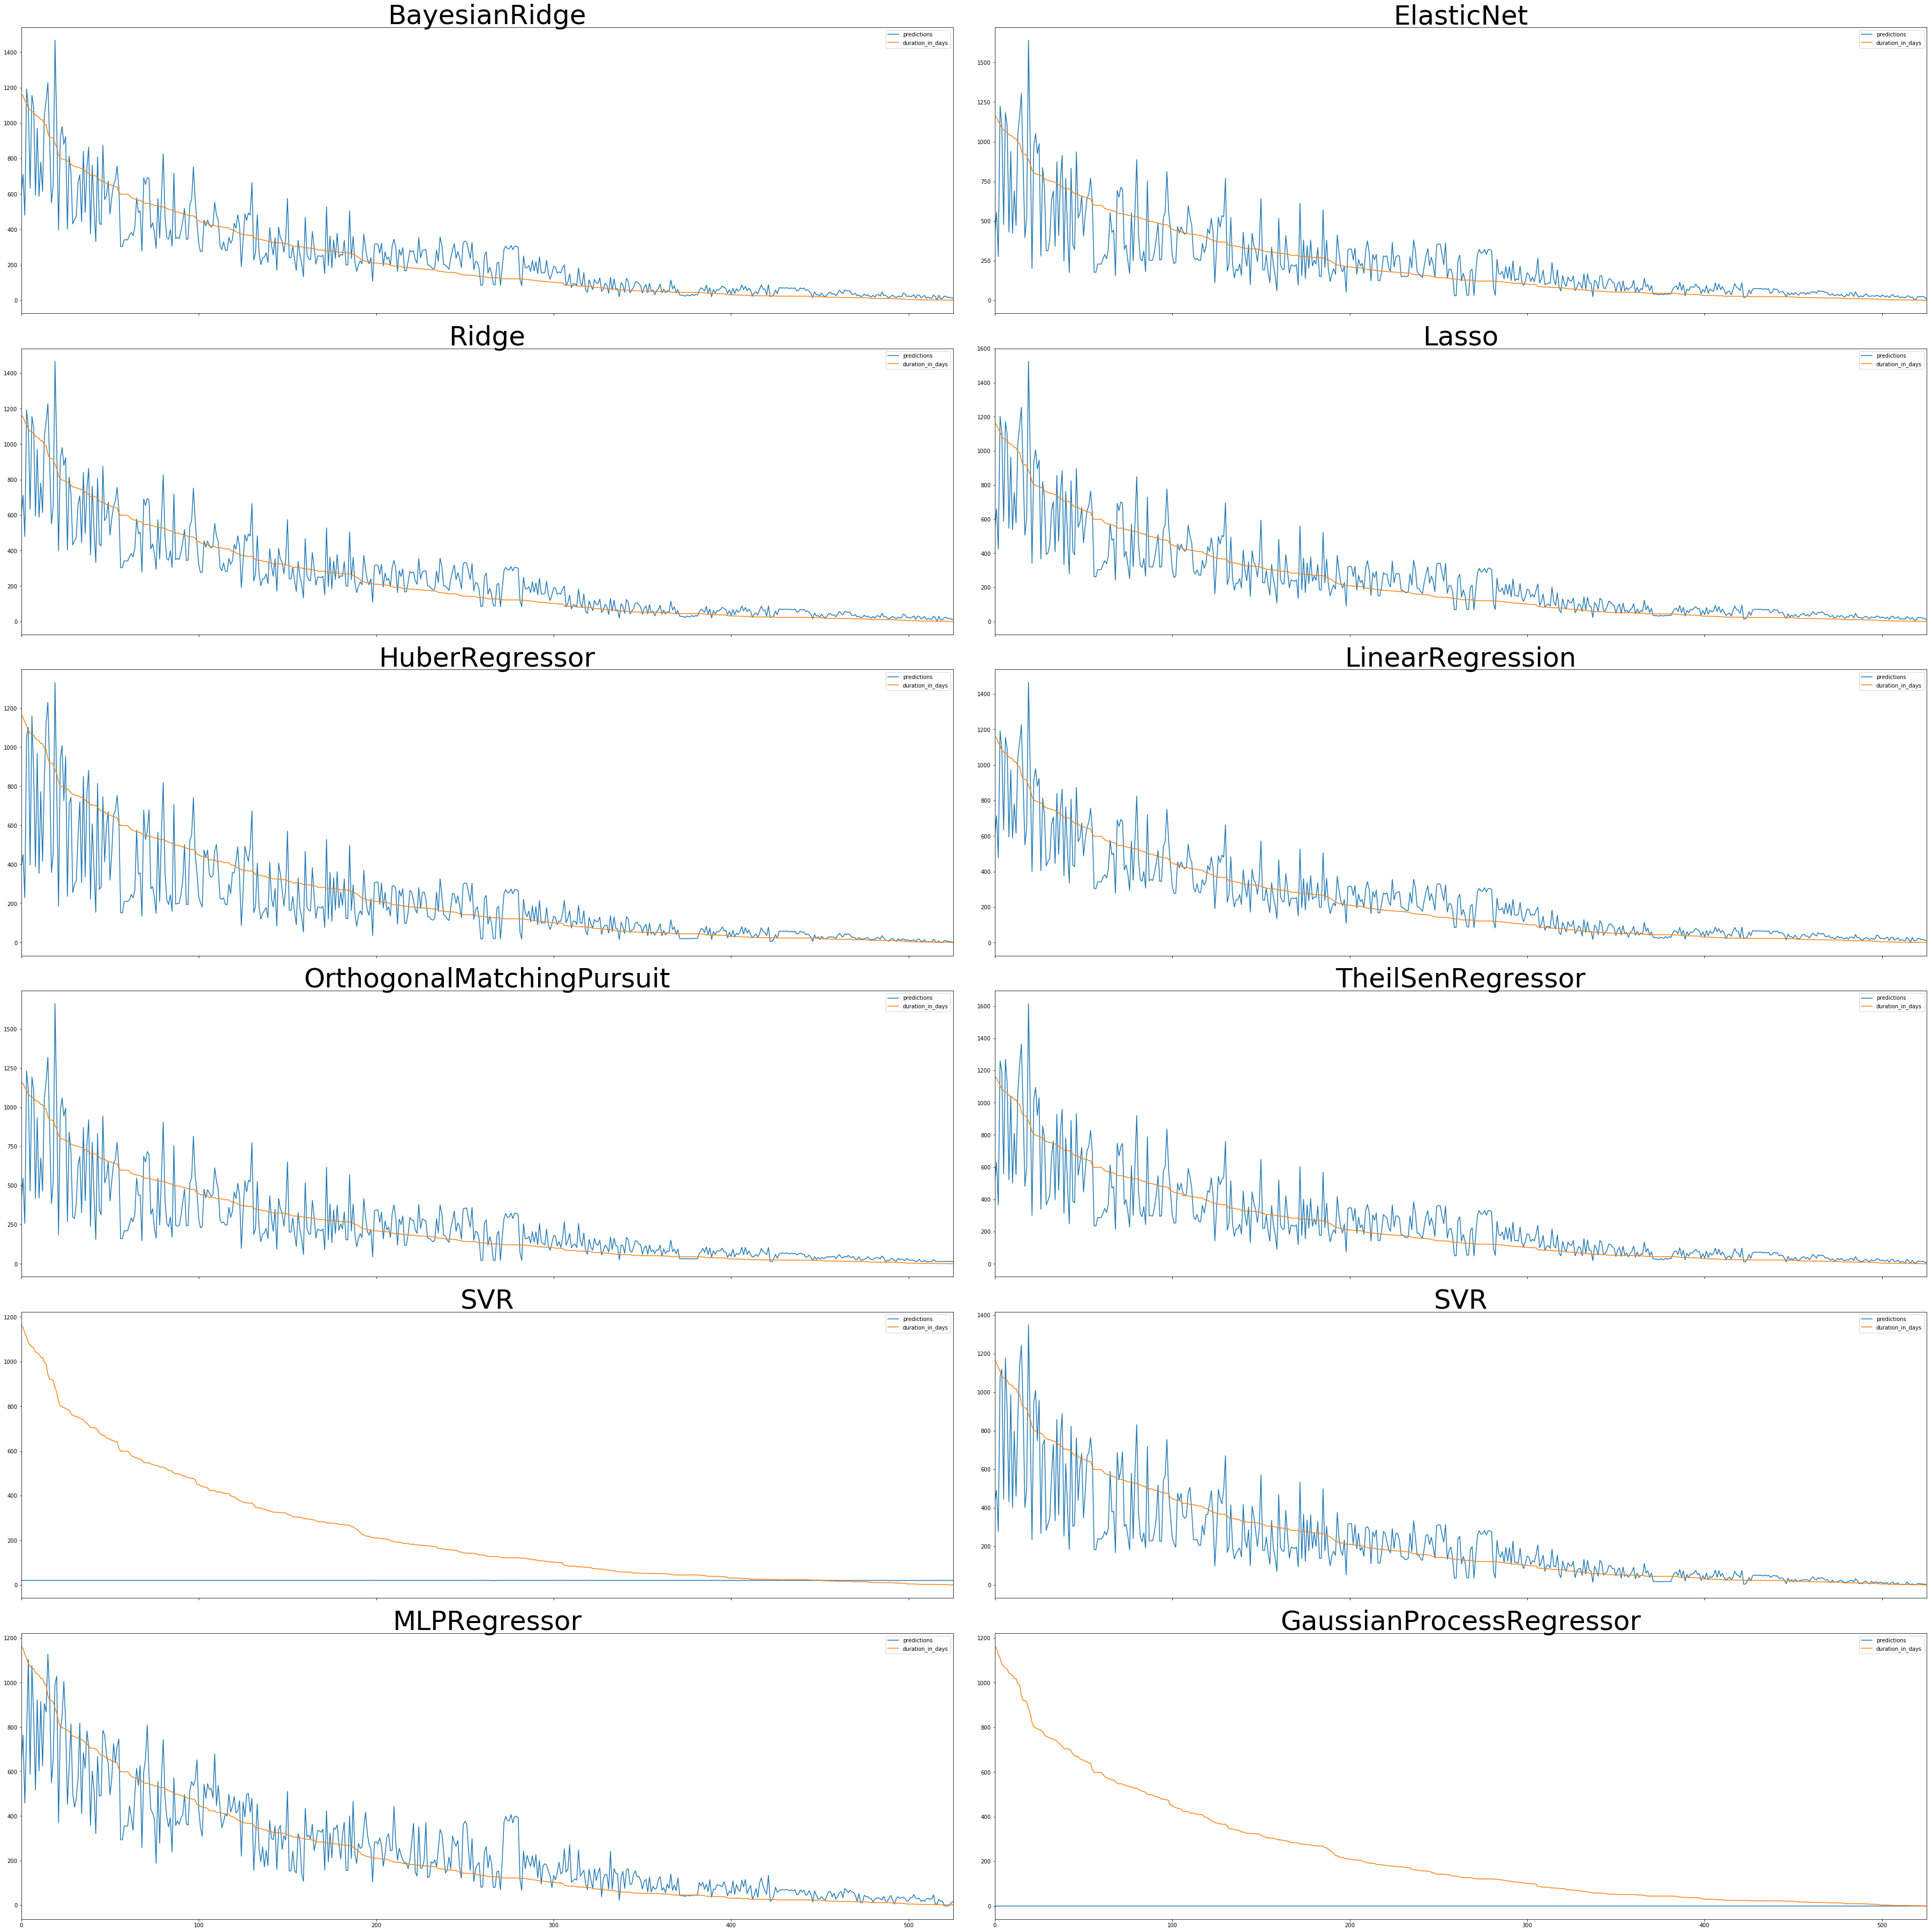

-----------------------------------------------
ExtraTreesRegressor
Train error is 0.018630
Test error is 0.641082
-----------------------------------------------
-----------------------------------------------
GradientBoostingRegressor
Train error is 0.750997
Test error is 0.746553
-----------------------------------------------
-----------------------------------------------
RandomForestRegressor
Train error is 0.317082
Test error is 0.610582
-----------------------------------------------
-----------------------------------------------
AdaBoostRegressor
Train error is 2.319098
Test error is 2.275277
-----------------------------------------------
-----------------------------------------------
BaggingRegressor
Train error is 0.306279
Test error is 0.610578
-----------------------------------------------
-----------------------------------------------
DecisionTreeRegressor
Train error is 0.018630
Test error is 0.743969
-----------------------------------------------


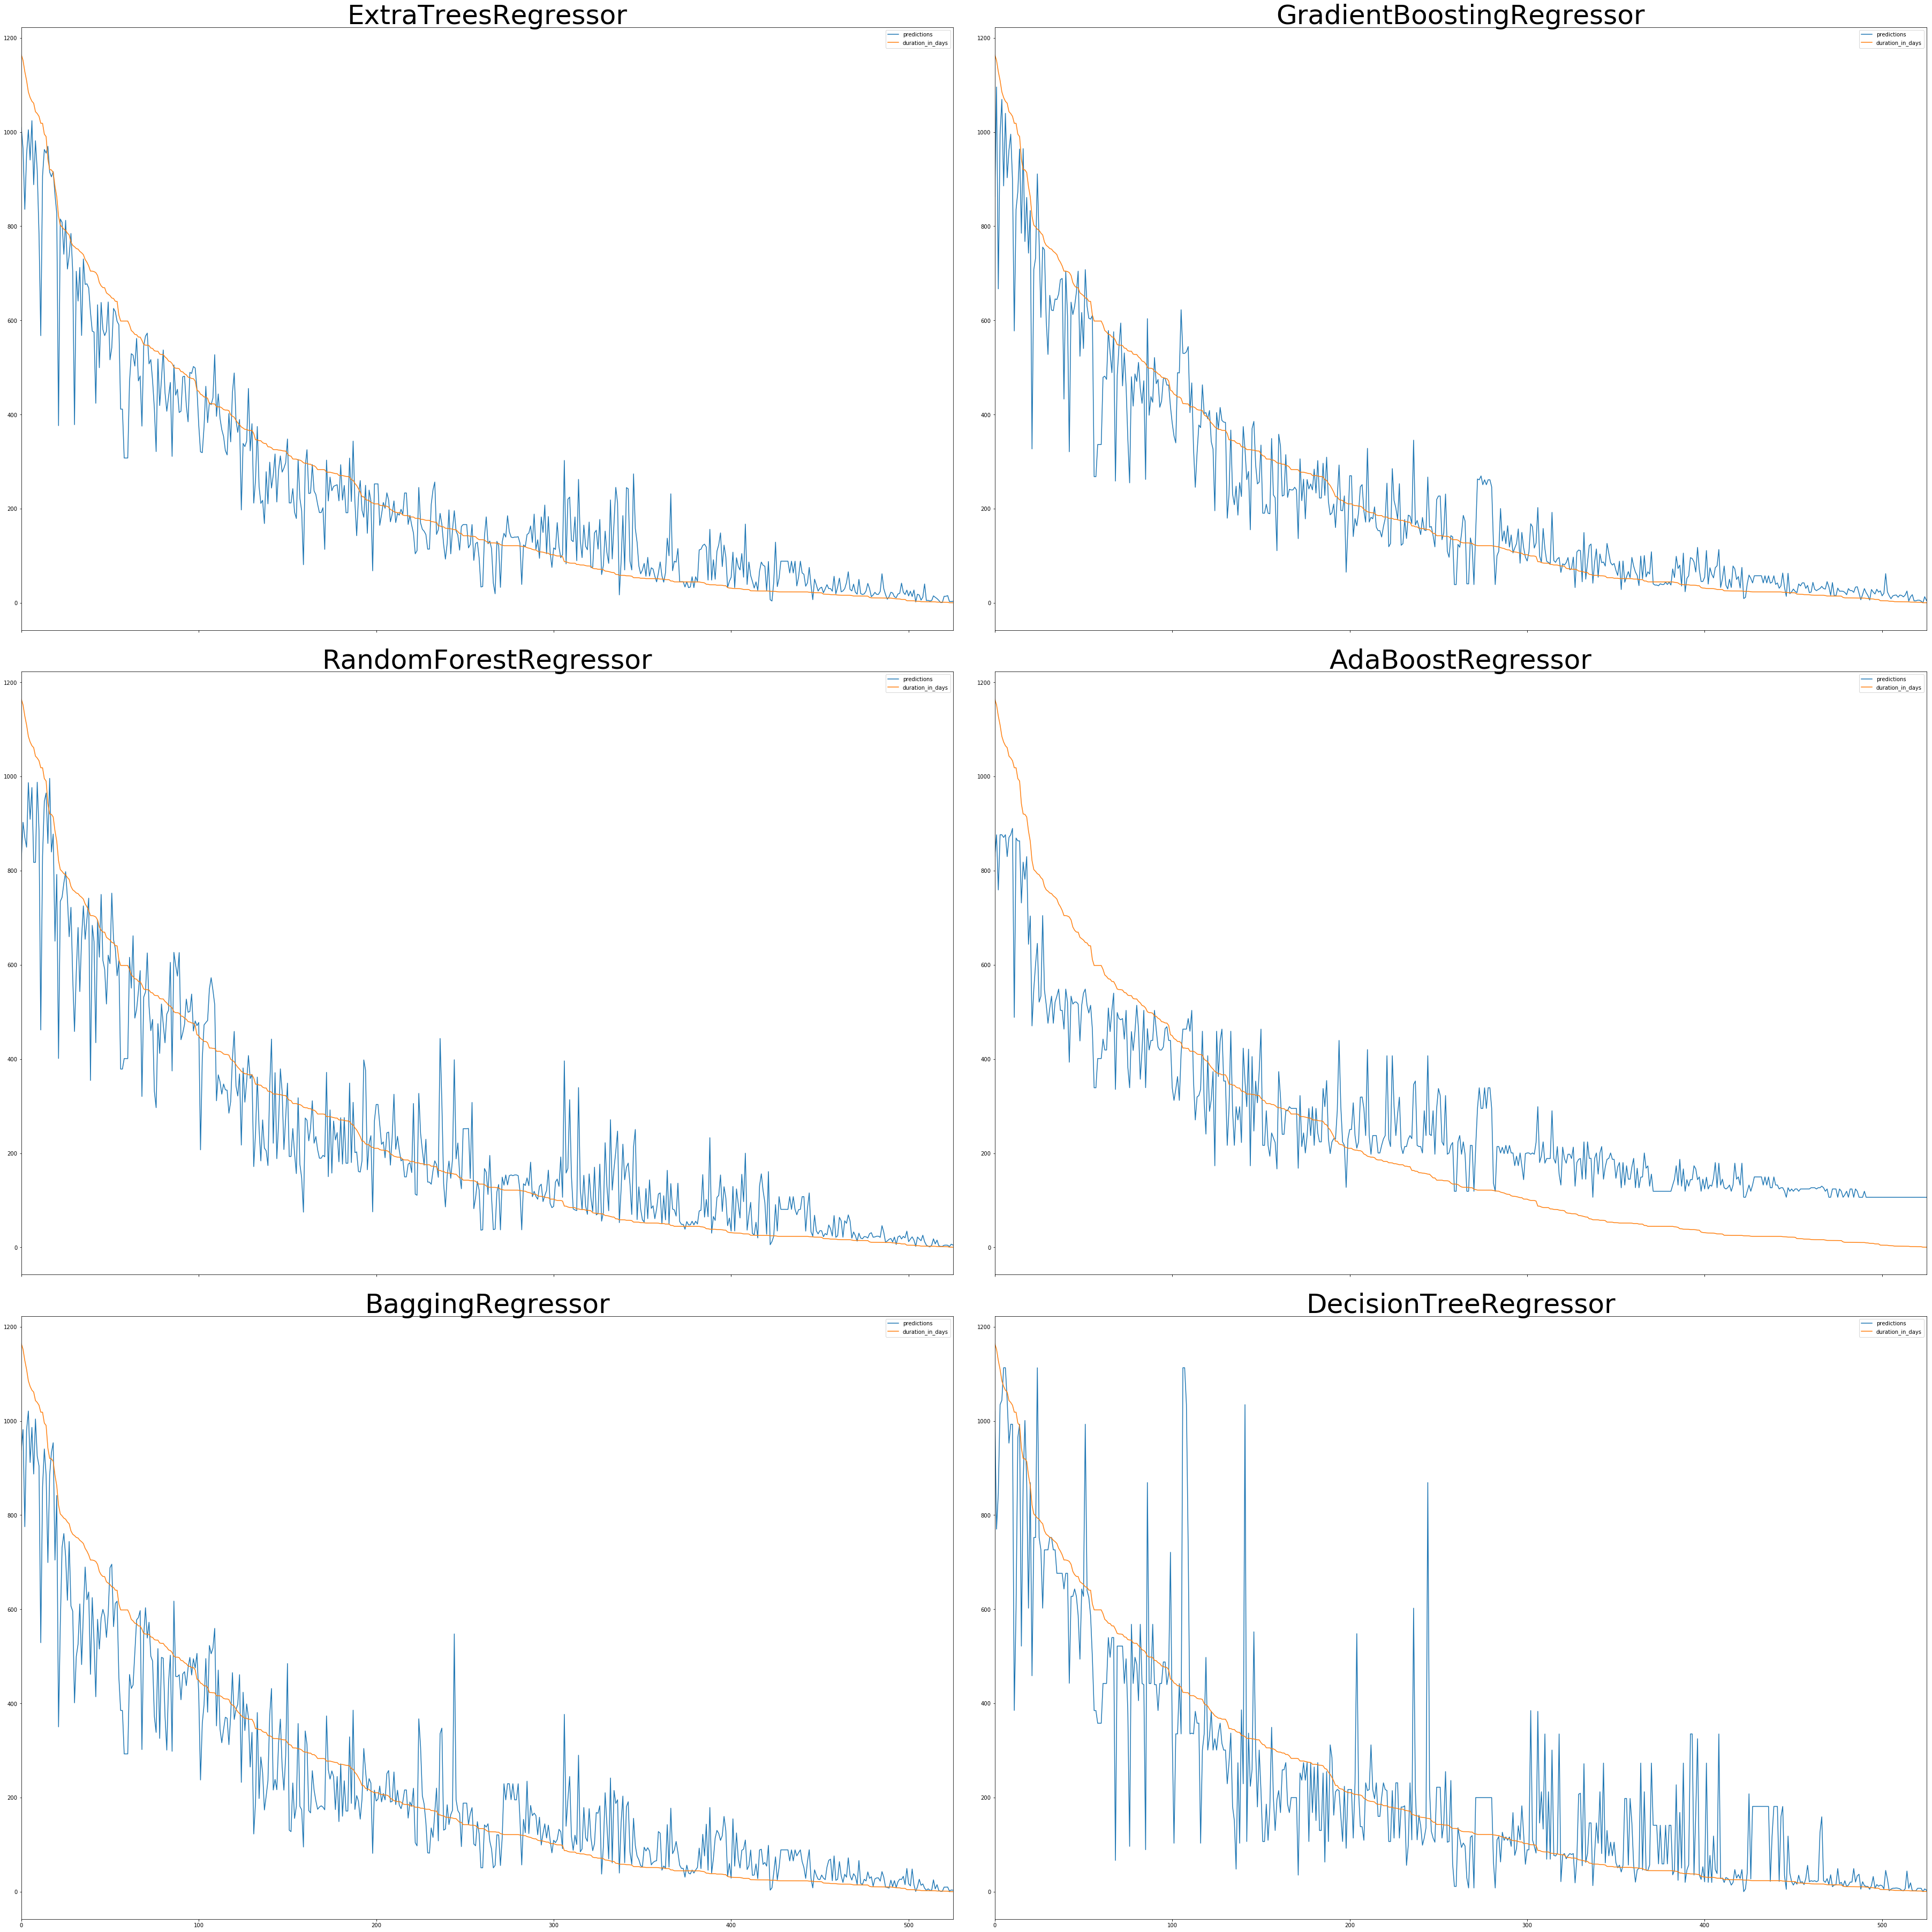

CPU times: user 1min 39s, sys: 43.2 s, total: 2min 23s
Wall time: 1min 5s


In [29]:
%%time
for models in ["linear", "tree"]:
    if models == "linear":
        models = [
            BayesianRidge(n_iter=500),
            ElasticNet(),
            Ridge(),
            Lasso(),
            HuberRegressor(),
            LinearRegression(),
            OrthogonalMatchingPursuit(),
            TheilSenRegressor(),
            SVR(kernel='rbf'),
            SVR(kernel='linear'),
            MLPRegressor(),
            GaussianProcessRegressor()

        ]
    elif models == "tree":
        models = [
            ExtraTreesRegressor(),
            GradientBoostingRegressor(),
            RandomForestRegressor(),
            AdaBoostRegressor(),
            BaggingRegressor(),
            DecisionTreeRegressor()
        ]
    fig, ax = plt.subplots(nrows=int(len(models)/2), ncols=2, figsize=(50,50), sharex=True, sharey=False, constrained_layout=True)
    row = 0
    col = 0
    for model in models:
        fit = model.fit(x_train, y_train)
        predict_df = times_open[x_train.columns]
        submit_predictions = pd.DataFrame(predict_df.index)
        submit_predictions["predictions"] = fit.predict(predict_df)
        mer = pd.merge(submit_predictions, wt_plot[["work_item", "duration_in_days"]], on="work_item")
        mer.plot(ax=ax[row][col])
        ax[row][col].set_title(str(model).split("(")[0], fontsize=50)
        train_predictions, test_predictions = train_test_predictions(x_train, x_test, fit, val=None)
        train_predictions["predictions"] = train_predictions.predictions.apply(lambda x: 0 if x<0 else x)
        test_predictions["predictions"] = test_predictions.predictions.apply(lambda x: 0 if x<0 else x)
        train_rmsle = my_rmsle(y_train.reset_index(), train_predictions, "work_item", "duration_in_days")
        test_rmsle = my_rmsle(y_test.reset_index(), test_predictions, "work_item", "duration_in_days")
        print("-----------------------------------------------")
        print(str(model).split("(")[0])
        print("Train error is %f" %train_rmsle)
        print("Test error is %f" %test_rmsle)
        print("-----------------------------------------------")
        if col == 1:
            col = 0
            row += 1
        else:
            col += 1
    plt.show()

In [33]:
svr = SVR(kernel='linear')
fit = svr.fit(x_train, y_train)
predict_df = times_open[x_train.columns]
submit_predictions = pd.DataFrame(predict_df.index)
submit_predictions["predictions"] = fit.predict(predict_df)
total_open = submission_correction(submit_predictions, total_times, times_open.reset_index())

In [34]:
train_predictions, test_predictions = train_test_predictions(x_train, x_test, fit, val=None)
train_predictions["predictions"] = train_predictions.predictions.apply(lambda x: 0 if x<0 else x)
test_predictions["predictions"] = test_predictions.predictions.apply(lambda x: 0 if x<0 else x)
train_rmsle = rmsle(y_train.reset_index(), train_predictions)
test_rmsle = rmsle(y_test.reset_index(), test_predictions)
print("Train error is %f" %train_rmsle)
print("Test error is %f" %test_rmsle)

Train error is 0.762513
Test error is 0.744165


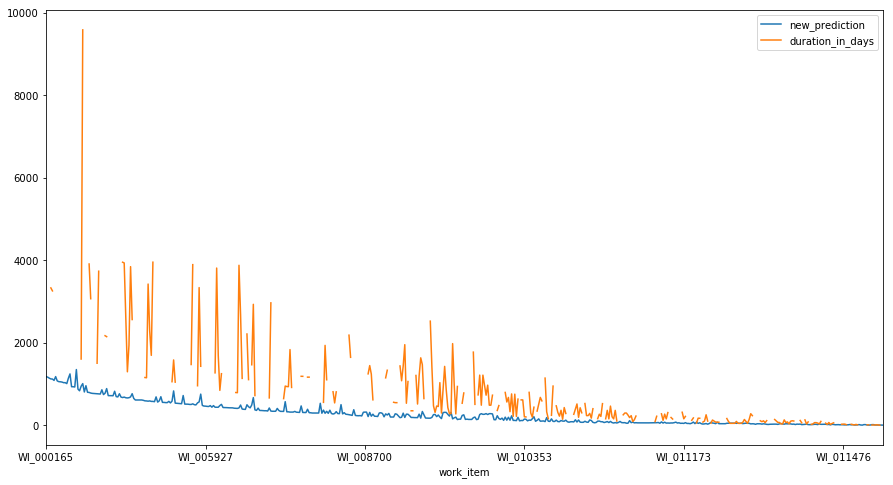

In [42]:
mer = pd.merge(total_open[["work_item", "new_prediction"]], wt_plot[["work_item", "duration_in_days"]], on="work_item", how="left")
mer.set_index("work_item").plot(figsize=(15,8))
plt.show()

In [29]:
# submit = total_open[["work_item", "new_prediction"]]
# submit.rename(columns={"new_prediction":"predictions"}, inplace=True)
# submit.to_csv("/apps/data/common/shared/190412_PredictionGroup2.csv", index=False)

# ANN

In [30]:
def init_model():
    model = keras.Sequential([
        keras.layers.Dense(256, activation=tf.nn.relu, input_shape=[len(x_train.columns)]),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(128, activation=tf.nn.relu),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(128, activation=tf.nn.relu),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation=tf.nn.relu),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(16, activation=tf.nn.relu),
        keras.layers.Dense(1, activation=tf.nn.relu)
            ])
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

In [31]:
model = init_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               5888      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_______________________________________

In [32]:
%%time
model.fit(x_train, y_train, epochs=100, shuffle=True, batch_size=70)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
6181/6181 [==============================] - 1s 103us/sample - loss: 9708.3701 - acc: 0.0021
Epoch 2/100
6181/6181 [==============================] - 0s 49us/sample - loss: 5925.9256 - acc: 0.0015
Epoch 3/100
6181/6181 [==============================] - 0s 49us/sample - loss: 5789.9052 - acc: 0.0015
Epoch 4/100
6181/6181 [==============================] - 0s 50us/sample - loss: 4932.1665 - acc: 0.0015
Epoch 5/100
6181/6181 [==============================] - 0s 50us/sample - loss: 4898.1345 - acc: 0.0015
Epoch 6/100
6181/6181 [==============================] - 0s 50us/sample - loss: 4834.3222 - acc: 0.0015
Epoch 7/100
6181/6181 [==============================] - 0s 49us/sample - loss: 5325.7688 - acc: 0.0015
Epoch 8/100
6181/6181 [==============================] - 0s 50us/sample - loss: 5420.5161 - acc: 0.0015
Epoch 9/100
6181/6181 [==============================] - 0s 50us/sample - loss: 4689.6054 - acc: 0.0015
Epoch 10/100
61

In [33]:
err, acc = model.evaluate(x_test, y_test)
print("The model has an error of %0.2f and an accuracy of %0.2f"%(err,acc))

2650/2650 [==============================] - 0s 55us/sample - loss: 7596.2490 - acc: 0.0019
The model has an error of 7596.25 and an accuracy of 0.00


In [34]:
predict_df = times_open[x_train.columns]
submit_predictions = pd.DataFrame(predict_df.index)
submit_predictions["predictions"] = model.predict(predict_df)

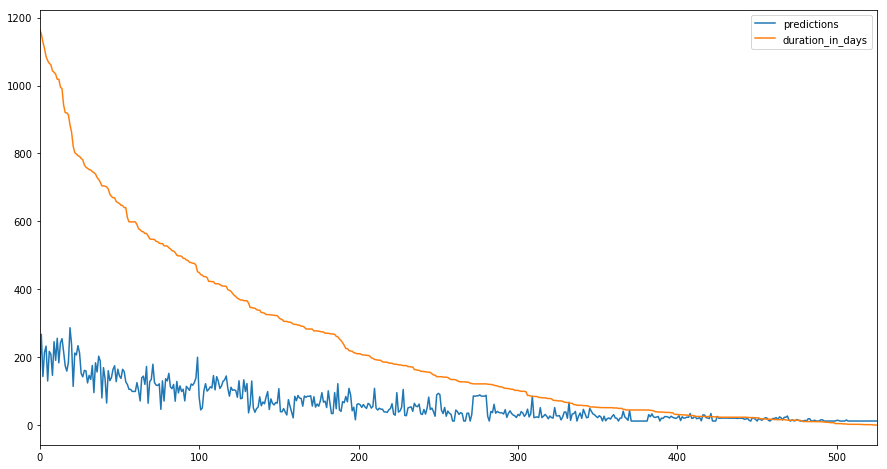

In [35]:
mer = pd.merge(submit_predictions, wt_plot[["work_item", "duration_in_days"]], on="work_item")
mer.plot(figsize=(15,8))

In [36]:
# train_predictions, test_predictions = train_test_predictions(x_train, x_test, fit, val=None)
# train_predictions["predictions"] = train_predictions.predictions.apply(lambda x: 0 if x<0 else x)
# test_predictions["predictions"] = test_predictions.predictions.apply(lambda x: 0 if x<0 else x)
# train_rmsle = rmsle(y_train.reset_index(), train_predictions)
# test_rmsle = rmsle(y_test.reset_index(), test_predictions)
# print("Train error is %f" %train_rmsle)
# print("Test error is %f" %test_rmsle)

# CNN & LSTM

In [37]:
final.reset_index(inplace=True)

In [38]:
is_op = final["is_open"]==1
times_open = final[is_op]
times_closed = final[~is_op]
print("We have %i open work_items and %i closed work_items"%(len(times_open), len(times_closed)))

We have 526 open work_items and 8831 closed work_items


In [39]:
n_timesteps = final.work_item.value_counts().max()
print("The maximum number of timesteps is "+str(n_timesteps))

The maximum number of timesteps is 1


In [41]:
# train_cols = list(set(times_closed.columns) - set(["duration_in_days", "work_item"]))
#train_cols = ['end_year', 'platcomp_cluster', 'start_year', 'x_load', 'resource_workload', 'x_exp', 'x_diff', 'open_item',
#               'start_week', 'resource_cluster', 'is_holiday', 'is_vacation', 'days_to_nextvac', 'days_to_nexthol', 'has_loops']
#                   set(["duration_in_days",  "start_month", "outlier_pred", "start_weekday", "start_day",
#                        "resource_cluster", "open_item", "has_loops", "x_emp", "end_week", "difficulty"]))
train_cols = list(set(times_closed.columns) - set(["work_item", "duration_in_days"]) - set(worktime_time.columns) - set(workfreq.columns))
# train_cols.append("Analyze")
# train_cols = ['end_year', 'platcomp_cluster', 'start_year', 'x_load', 'x_exp', 'start_week', 'skipped_days']

In [42]:
n_samples = times_closed.work_item.nunique()
n_features = len(train_cols)
print("We have %i samples, %i timesteps and %i features"%(n_samples, n_timesteps, n_features))

We have 8831 samples, 1 timesteps and 22 features


In [43]:
x_data = np.zeros(shape=(n_samples, n_timesteps, n_features))
y_data = np.zeros(shape=(n_samples, 1))
x = np.array(list(times_closed.groupby("work_item").apply(lambda x: np.array(x[train_cols]))))
y_data = np.array(list(times_closed.groupby("work_item").apply(lambda x: x["duration_in_days"].values[0]))).reshape(n_samples, 1)
for i in range(0, times_closed.work_item.nunique()):
    x_data[i, 0:len(x[i])] = x[i]
print("We have the X data in shape {} and the Y data in shape {}".format(x_data.shape, y_data.shape))

We have the X data in shape (8831, 1, 22) and the Y data in shape (8831, 1)


In [44]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)
print("x-train data shape = {}".format(x_train.shape))
print("Y-train data shape = {}".format(y_train.shape))

x-train data shape = (6181, 1, 22)
Y-train data shape = (6181, 1)


In [45]:
def init_CNN(n_timesteps, n_features):
    model = keras.Sequential([
        keras.layers.Conv1D(512, kernel_size=1, activation=tf.nn.relu, input_shape=(n_timesteps, n_features)),
        keras.layers.MaxPool1D(pool_size=1),
        keras.layers.Dropout(0.3),
        keras.layers.Conv1D(512, kernel_size=1, activation=tf.nn.relu),
        keras.layers.MaxPool1D(pool_size=1),
        keras.layers.Dropout(0.3),
        keras.layers.Conv1D(256, kernel_size=1, activation=tf.nn.relu),
        keras.layers.MaxPool1D(pool_size=1),
        keras.layers.Dropout(0.3),
        keras.layers.Conv1D(256, kernel_size=1, activation=tf.nn.relu),
        keras.layers.MaxPool1D(pool_size=1),
        keras.layers.Flatten(),
#         keras.layers.Dense(64, activation=tf.nn.relu),
#         keras.layers.Dense(32, activation=tf.nn.relu),
#         keras.layers.Dense(16, activation=tf.nn.relu),
        keras.layers.Dense(1)
            ])
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

In [46]:
model = init_CNN(n_timesteps, n_features)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 512)            11776     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 512)            0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 512)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 512)            262656    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 512)            0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 512)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 256)            131328    
__________

In [47]:
%%time
model.fit(x_train, y_train, epochs=100, batch_size=50)

Epoch 1/100
6181/6181 [==============================] - 2s 264us/sample - loss: 4450.2856 - acc: 0.0015
Epoch 2/100
6181/6181 [==============================] - 1s 225us/sample - loss: 3465.6901 - acc: 0.0015
Epoch 3/100
6181/6181 [==============================] - 1s 226us/sample - loss: 3275.9113 - acc: 0.0015
Epoch 4/100
6181/6181 [==============================] - 1s 225us/sample - loss: 3098.6332 - acc: 0.0015
Epoch 5/100
6181/6181 [==============================] - 1s 226us/sample - loss: 3132.7121 - acc: 0.0015
Epoch 6/100
6181/6181 [==============================] - 1s 226us/sample - loss: 3065.7702 - acc: 0.0015
Epoch 7/100
6181/6181 [==============================] - 1s 225us/sample - loss: 2938.5713 - acc: 0.0015
Epoch 8/100
6181/6181 [==============================] - 1s 225us/sample - loss: 2880.8555 - acc: 0.0015
Epoch 9/100
6181/6181 [==============================] - 1s 226us/sample - loss: 2798.3631 - acc: 0.0015
Epoch 10/100
6181/6181 [==============================]

In [48]:
err, acc = model.evaluate(x_test, y_test)
print("The model has an error of %0.2f and an accuracy of %0.2f"%(err,acc))

2650/2650 [==============================] - 0s 69us/sample - loss: 1343.0708 - acc: 0.0019
The model has an error of 1343.07 and an accuracy of 0.00


In [62]:
n_samples = times_open.work_item.nunique()
x_predict = np.zeros(shape=(n_samples, n_timesteps, n_features))
x_pred = np.array(list(times_open.groupby("work_item").apply(lambda x: np.array(x[train_cols]))))
for i in range(0, times_open.work_item.nunique()):
    x_predict[i, 0:len(x_pred[i])] = x_pred[i]
print("We have the prediction X data in shape {}".format(x_predict.shape))

We have the prediction X data in shape (526, 1, 22)


In [63]:
prediction = model.predict(x_predict)
submit_predictions = pd.DataFrame(data=prediction, index=times_open.work_item.unique()).reset_index().rename(columns={"index": "work_item"})

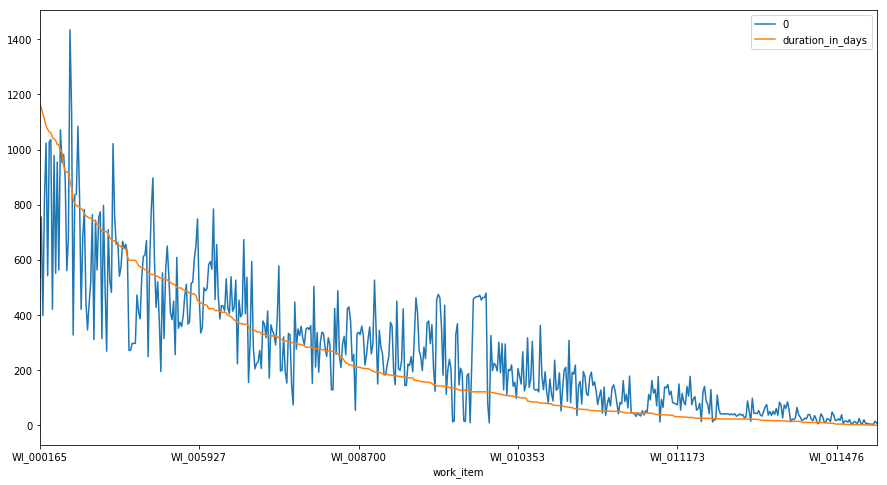

In [64]:
mer = pd.merge(submit_predictions, wt_plot[["work_item", "duration_in_days"]], on="work_item", how="left")
mer.set_index("work_item").plot(figsize=(15,8))
plt.show()

In [65]:
# total_open = submission_correction(submit_predictions)
# mer = pd.merge(total_open[["work_item", "new_prediction"]], wt_plot[["work_item", "duration_in_days"]], on="work_item", how="left")
# mer.set_index("work_item").plot(figsize=(15,8))
# plt.show()

In [66]:
train_pred = model.predict(x_train)
train_pred[train_pred < 0] = 0
test_pred = model.predict(x_test)
test_pred[test_pred < 0] = 0
train_rmsle = np.sqrt(sum(((np.log(y_train + 1) - np.log(train_pred + 1)) ** 2)) / len(y_train))
test_rmsle = np.sqrt(sum(((np.log(y_test + 1) - np.log(test_pred + 1)) ** 2)) / len(y_test))
print("Train error is %f" %train_rmsle)
print("Test error is %f" %test_rmsle)

Train error is 0.806984
Test error is 0.823217


In [75]:
def init_LSTM(n_timesteps, n_features):
    model = keras.Sequential([
        keras.layers.Conv1D(512, kernel_size=1, activation=tf.nn.relu, input_shape=(n_timesteps, n_features)),
        keras.layers.MaxPool1D(pool_size=1),
        keras.layers.LSTM(512, return_sequences=True),
        keras.layers.Dropout(0.5),
        keras.layers.Conv1D(256, kernel_size=1, activation=tf.nn.relu),
        keras.layers.MaxPool1D(pool_size=1),
        keras.layers.LSTM(256, return_sequences=True),
        keras.layers.Dropout(0.5),
        keras.layers.LSTM(256, return_sequences=True),
        keras.layers.Dropout(0.3),
        keras.layers.Conv1D(128, kernel_size=1, activation=tf.nn.relu),
        keras.layers.MaxPool1D(pool_size=1),
        keras.layers.LSTM(128),
        keras.layers.Flatten(),
        keras.layers.Dense(1)
            ])
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

In [76]:
model = init_CNN(n_timesteps, n_features)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 1, 512)            11776     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 1, 512)            0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 1, 512)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 1, 512)            262656    
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 1, 512)            0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 1, 512)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 1, 256)            131328    
__________

In [77]:
%%time
model.fit(x_train, y_train, epochs=1000, batch_size=50, shuffle=True)

Epoch 1/1000
6181/6181 [==============================] - 2s 277us/sample - loss: 4277.1407 - acc: 0.0013
Epoch 2/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 3818.1602 - acc: 0.0015
Epoch 3/1000
6181/6181 [==============================] - 1s 231us/sample - loss: 3204.5491 - acc: 0.0015
Epoch 4/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 3017.1595 - acc: 0.0015
Epoch 5/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 2956.6511 - acc: 0.0015
Epoch 6/1000
6181/6181 [==============================] - 1s 229us/sample - loss: 2893.3690 - acc: 0.0015
Epoch 7/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 2746.0107 - acc: 0.0015
Epoch 8/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 2989.6755 - acc: 0.0015
Epoch 9/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 2499.3788 - acc: 0.0015
Epoch 10/1000
6181/6181 [=====================

6181/6181 [==============================] - 1s 230us/sample - loss: 761.2490 - acc: 0.0013
Epoch 154/1000
6181/6181 [==============================] - 1s 231us/sample - loss: 747.0047 - acc: 0.0015
Epoch 155/1000
6181/6181 [==============================] - 1s 233us/sample - loss: 730.2321 - acc: 0.0015
Epoch 156/1000
6181/6181 [==============================] - 1s 233us/sample - loss: 627.0738 - acc: 0.0015
Epoch 157/1000
6181/6181 [==============================] - 1s 235us/sample - loss: 726.6844 - acc: 0.0015
Epoch 158/1000
6181/6181 [==============================] - 1s 234us/sample - loss: 934.7466 - acc: 0.0015
Epoch 159/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 746.1701 - acc: 0.0015
Epoch 160/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 679.6219 - acc: 0.0015
Epoch 161/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 719.9322 - acc: 0.0016
Epoch 162/1000
6181/6181 [==========================

6181/6181 [==============================] - 1s 230us/sample - loss: 537.0705 - acc: 0.0013
Epoch 306/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 497.3952 - acc: 0.0015
Epoch 307/1000
6181/6181 [==============================] - 1s 229us/sample - loss: 577.2162 - acc: 0.0018
Epoch 308/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 530.1894 - acc: 0.0016
Epoch 309/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 533.4403 - acc: 0.0018
Epoch 310/1000
6181/6181 [==============================] - 1s 229us/sample - loss: 490.9917 - acc: 0.0013
Epoch 311/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 449.3706 - acc: 0.0016
Epoch 312/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 502.7779 - acc: 0.0013
Epoch 313/1000
6181/6181 [==============================] - 1s 229us/sample - loss: 485.8898 - acc: 0.0016
Epoch 314/1000
6181/6181 [==========================

6181/6181 [==============================] - 1s 229us/sample - loss: 490.8052 - acc: 0.0015
Epoch 458/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 395.0249 - acc: 0.0016
Epoch 459/1000
6181/6181 [==============================] - 1s 231us/sample - loss: 399.0151 - acc: 0.0013
Epoch 460/1000
6181/6181 [==============================] - 1s 231us/sample - loss: 483.3819 - acc: 0.0021
Epoch 461/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 431.2501 - acc: 0.0018
Epoch 462/1000
6181/6181 [==============================] - 1s 229us/sample - loss: 482.7206 - acc: 0.0018
Epoch 463/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 420.4947 - acc: 0.0015
Epoch 464/1000
6181/6181 [==============================] - 1s 229us/sample - loss: 406.3780 - acc: 0.0013
Epoch 465/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 429.7266 - acc: 0.0018
Epoch 466/1000
6181/6181 [==========================

6181/6181 [==============================] - 1s 230us/sample - loss: 425.7037 - acc: 0.0019
Epoch 610/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 495.8941 - acc: 0.0015
Epoch 611/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 402.9040 - acc: 0.0019
Epoch 612/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 426.3362 - acc: 0.0015
Epoch 613/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 413.3157 - acc: 0.0016
Epoch 614/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 438.4597 - acc: 0.0016
Epoch 615/1000
6181/6181 [==============================] - 1s 231us/sample - loss: 388.0137 - acc: 0.0016
Epoch 616/1000
6181/6181 [==============================] - 1s 229us/sample - loss: 364.0434 - acc: 0.0018
Epoch 617/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 449.3890 - acc: 0.0018
Epoch 618/1000
6181/6181 [==========================

6181/6181 [==============================] - 1s 230us/sample - loss: 333.1391 - acc: 0.0015
Epoch 762/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 334.9534 - acc: 0.0018
Epoch 763/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 359.8696 - acc: 0.0019
Epoch 764/1000
6181/6181 [==============================] - 1s 229us/sample - loss: 313.7648 - acc: 0.0019
Epoch 765/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 315.5222 - acc: 0.0019
Epoch 766/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 359.5631 - acc: 0.0016
Epoch 767/1000
6181/6181 [==============================] - 1s 230us/sample - loss: 415.0420 - acc: 0.0021
Epoch 768/1000
6181/6181 [==============================] - 1s 235us/sample - loss: 392.9515 - acc: 0.0018
Epoch 769/1000
6181/6181 [==============================] - 1s 231us/sample - loss: 355.3405 - acc: 0.0013
Epoch 770/1000
6181/6181 [==========================

KeyboardInterrupt: 

In [78]:
err, acc = model.evaluate(x_test, y_test)
print("The model has an error of %0.2f and an accuracy of %0.2f"%(err,acc))

2650/2650 [==============================] - 0s 90us/sample - loss: 1880.3671 - acc: 0.0019
The model has an error of 1880.37 and an accuracy of 0.00


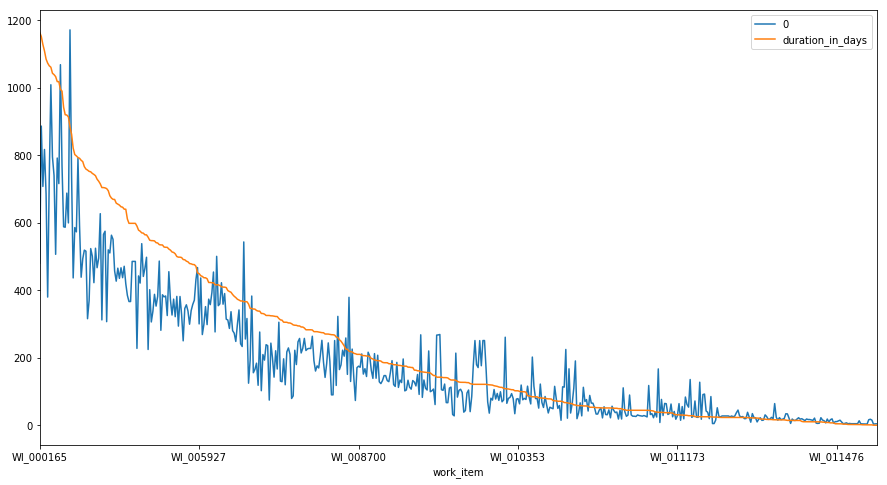

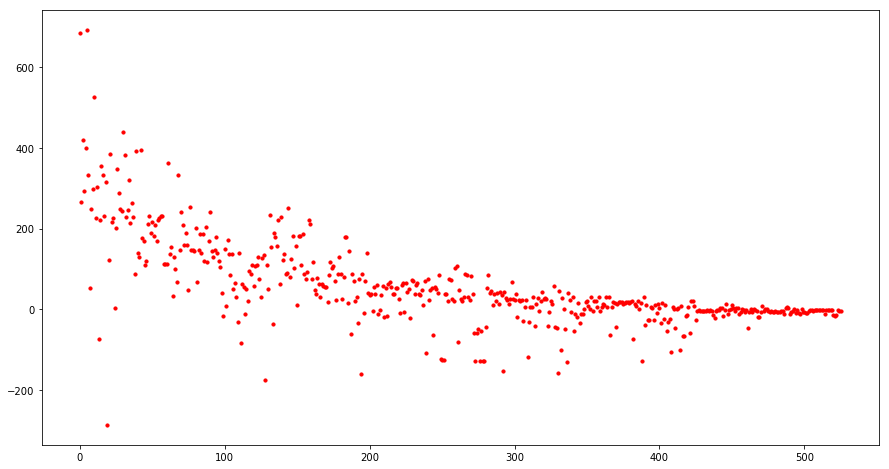

In [79]:
prediction = model.predict(x_predict)
submit_predictions = pd.DataFrame(data=prediction, index=times_open.work_item.unique()).reset_index().rename(columns={"index": "work_item"})
mer = pd.merge(submit_predictions, wt_plot[["work_item", "duration_in_days"]], on="work_item", how="left")
mer.set_index("work_item").plot(figsize=(15,8))
plt.figure(figsize=(15,8))
mer.loc[:, "delta"] = mer["duration_in_days"] - mer[0]
# plt.scatter(x=mer.index, y=mer["Design"], s=10, color='g')
plt.scatter(x=mer.index, y=mer["delta"], s=10, color='r')
plt.show()

In [73]:
train_pred = model.predict(x_train)
train_pred[train_pred < 0] = 0
test_pred = model.predict(x_test)
test_pred[test_pred < 0] = 0
train_rmsle = np.sqrt(sum(((np.log(y_train + 1) - np.log(train_pred + 1)) ** 2)) / len(y_train))
test_rmsle = np.sqrt(sum(((np.log(y_test + 1) - np.log(test_pred + 1)) ** 2)) / len(y_test))
print("Train error is %f" %train_rmsle)
print("Test error is %f" %test_rmsle)

Train error is 0.840062
Test error is 0.847739


In [74]:
prediction.shape

(526, 1)

# TF Probability Model

In [201]:
def init_TFProba(n_timesteps, n_features):
    model = keras.Sequential([
        keras.layers.Dense(1, input_shape=(n_timesteps, n_features)),
        tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t, scale=1)),
        keras.layers.Dense(1)
    ])
#     negloglik = lambda y, p_y: -p_y.log_prob(y)
    model.compile(loss="mse", optimizer='adam')
    return model

In [202]:
model = init_TFProba(n_timesteps, n_features)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 1, 1)              8         
_________________________________________________________________
distribution_lambda_17 (Dist [(None, 1, 1), (None, 1,  0         
_________________________________________________________________
dense_41 (Dense)             (None, 1, 1)              2         
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [203]:
%%time
model.fit(x_train, y_train, epochs=10, batch_size=50)

Epoch 1/10
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_592:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_590:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_588:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_586:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_584:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_582:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_580:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_578:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_576:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_574:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_572:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_570:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_568:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_566:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_564:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_562:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_560:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_558:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_556:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_554:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_552:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_550:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_548:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_546:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_544:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_542:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_540:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_538:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_536:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_534:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_532:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_530:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'VarIsInitializedOp_528:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/opt/conda/lib/python

AttributeError: 'Tensor' object has no attribute 'is_initialized'

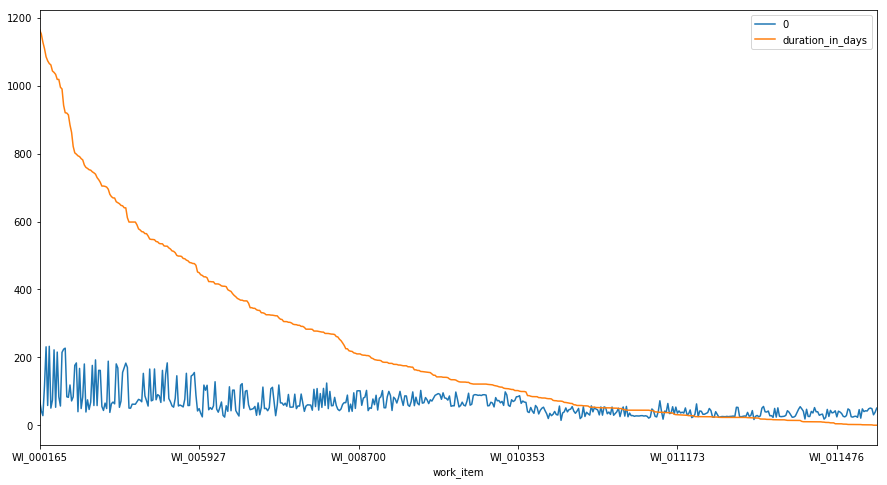

In [189]:
prediction = model.predict(x_predict).reshape(n_samples, 1)
submit_predictions = pd.DataFrame(data=prediction, index=times_open.work_item.unique()).reset_index().rename(columns={"index": "work_item"})
mer = pd.merge(submit_predictions, wt_plot[["work_item", "duration_in_days"]], on="work_item", how="left")
mer.set_index("work_item").plot(figsize=(15,8))
plt.show()

In [120]:
# train_pred = model.predict(x_train)
# test_pred = model.predict(x_test)
# train_rmsle = np.sqrt(sum(((np.log(y_train + 1) - np.log(train_pred + 1)) ** 2)) / len(y_train))
# test_rmsle = np.sqrt(sum(((np.log(y_test + 1) - np.log(test_pred + 1)) ** 2)) / len(y_test))
# print("Train error is %f" %train_rmsle)
# print("Test error is %f" %test_rmsle)